# CNN test 1

Ok let's train a CNN on this thing

In [1]:
import os
import time
import h5py
import numpy as np
import math

from tqdm import tqdm, trange
from matplotlib import pyplot as plt
from pprint import pprint

In [2]:
# Utility functions and whatnot
def convert_size(size_bytes):
    if size_bytes == 0:
        return "0B"
    size_name = ("B", "KB", "MB", "GB", "TB", "PB", "EB", "ZB", "YB")
    i = int(math.floor(math.log(size_bytes, 1024)))
    p = math.pow(1024, i)
    s = round(size_bytes / p, 2)
    return "%s %s" % (s, size_name[i])


class_labels = ["pion", "photon", "scalar"]

In [3]:
data_dir = "/usatlas/atlas01/atlasdisk/users/atlas_wifeng/photon-jet/data/processed/scalar_test"
os.chdir(data_dir)

In [4]:
# Grab the data
all_jets = np.load("all_jets.npz")

for layer, arr in all_jets.items():
    print(
        layer.ljust(10),
        str(arr.dtype).ljust(15),
        str(arr.shape).ljust(20),
        convert_size(arr.nbytes)
    )

layer_0    float64         (300000, 4, 16)      146.48 MB
layer_1    float64         (300000, 4, 128)     1.14 GB
layer_2    float64         (300000, 16, 16)     585.94 MB
layer_3    float64         (300000, 16, 8)      292.97 MB
energy     float64         (300000, 1)          2.29 MB
overflow   float64         (300000, 4)          9.16 MB
label      int64           (300000,)            2.29 MB


## Visualize some data

Just to see what jets look like. Utility functions defined here:
- `nth_jet(n)`: displays the `n`th jet from `all_jets`
- `graph_jet(jet)`: graphs a jet (a dict with `energy`, `layer_0`, ..., `label` keys)

TODO: add together stuff for each class

In [5]:
def nth_jet(n):
    jet = {}
    for layer in all_jets.keys():
        jet[layer] = all_jets[layer][n]
    return jet

def graph_jet(jet):
    fig, axs = plt.subplots(1, 4, figsize=(20, 4))
    for layer, ax in zip(["layer_0", "layer_1", "layer_2", "layer_3"], axs):
        im = ax.imshow(
            jet[layer].T,
            interpolation='none',
            cmap="viridis",
            extent=[-0.2, 0.2, -0.02, 0.02],
            aspect=10
        )
        ax.set_title(layer)
        
    fig.suptitle(class_labels[jet['label']])
    fig.colorbar(im, ax=axs.ravel().tolist())
    
    print(f"Layers for {class_labels[jet['label']]} (class {jet['label']})")
    plt.show()
    if "energy" in jet: print(f"energy:   {jet['energy']}")
    if "overflow" in jet: print(f"overflow: {jet['overflow']}")

Layers for pion (class 0)


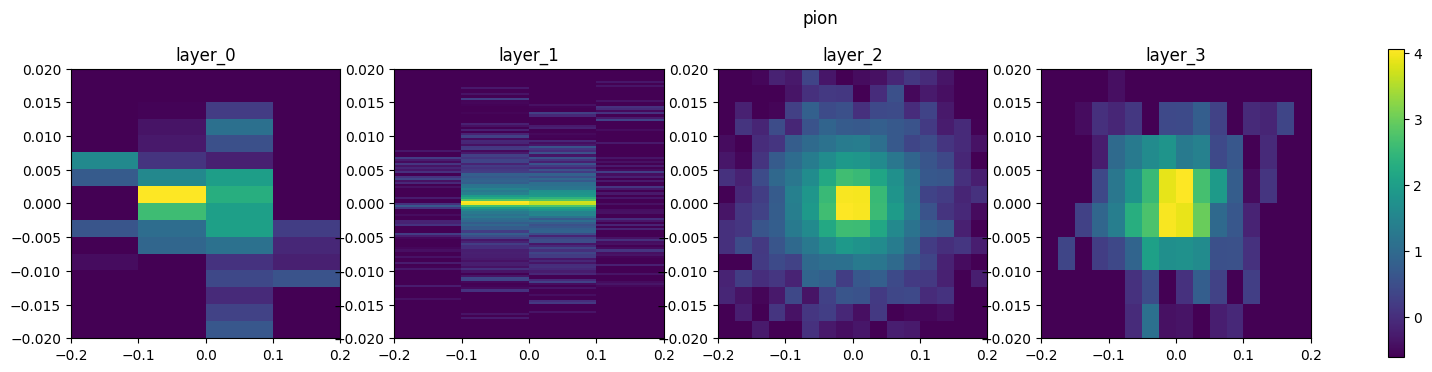

energy:   [194.16822516]
overflow: [ 2.48108438  6.39414752 62.47938928  0.        ]
Layers for photon (class 1)


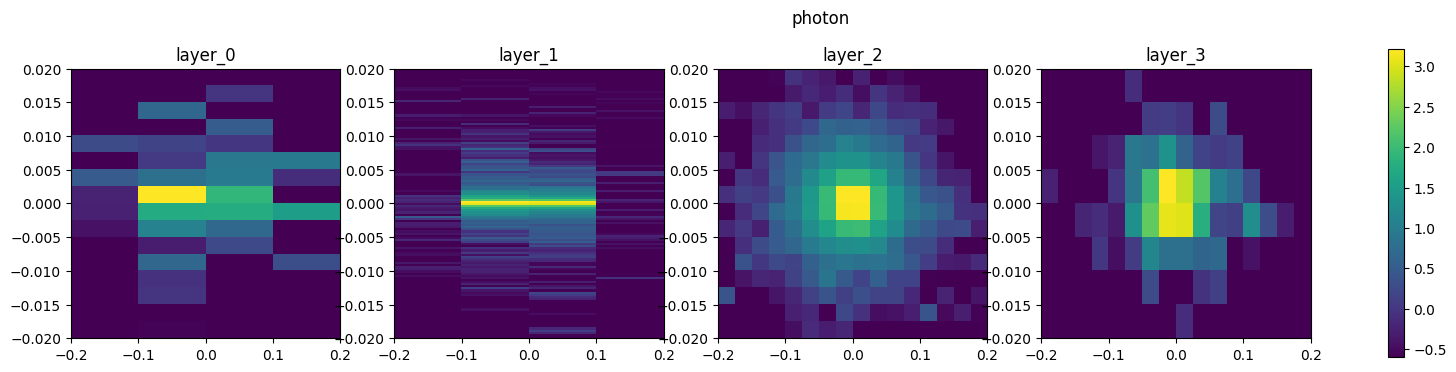

energy:   [108.89270262]
overflow: [ 0.          8.64947689 40.24732128  0.        ]
Layers for scalar (class 2)


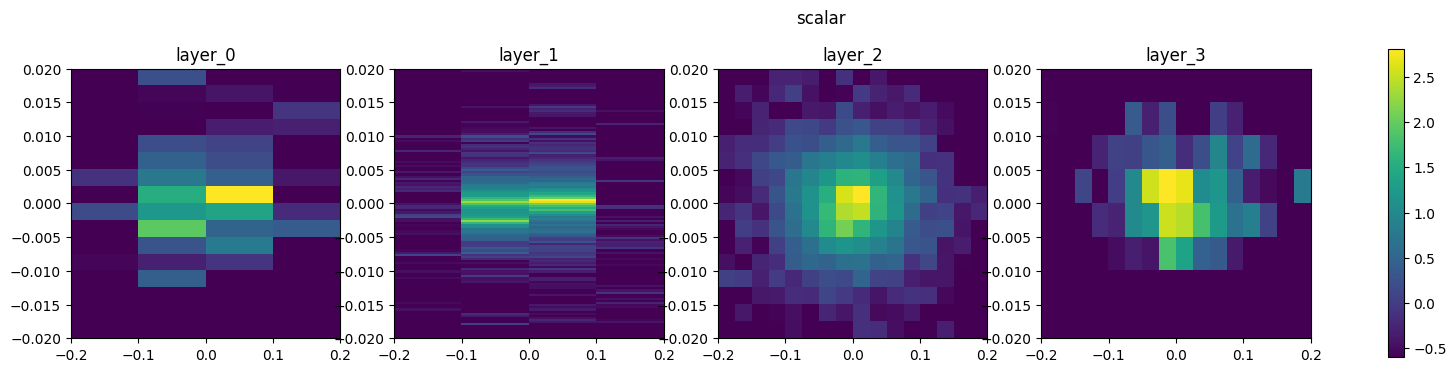

energy:   [91.87980075]
overflow: [ 6.32856116  6.12208639 25.14565516  0.4459802 ]


In [6]:
example_idxs = [None] * 3
i = 0
while True:
    label = all_jets["label"][i]
    if example_idxs[label] == None:
        example_idxs[label] = i
    if all(x != None for x in example_idxs):
        break
    i += 1
    
for i in example_idxs:
    graph_jet(nth_jet(i))

Layers for pion (class 0)


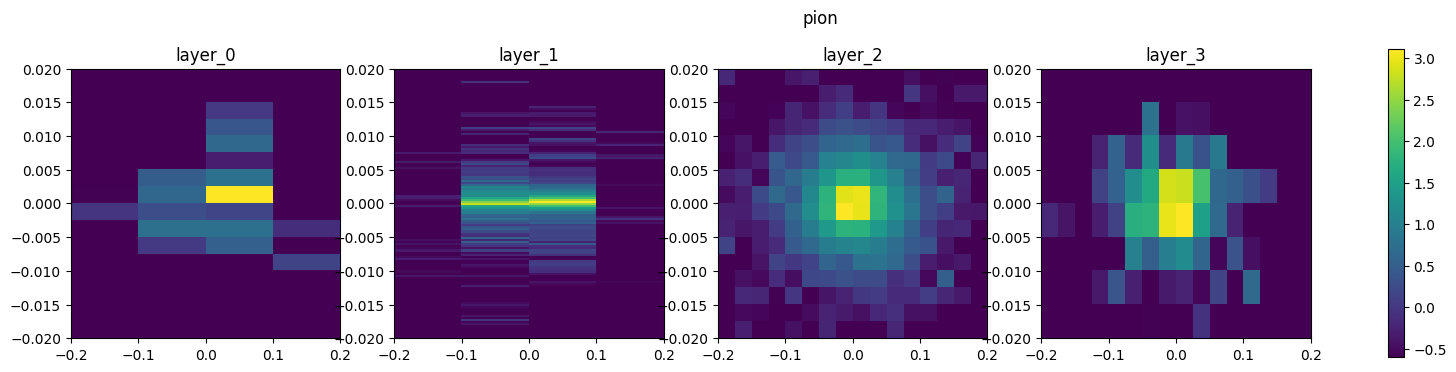

energy:   [77.67219096]
overflow: [ 1.17420885  4.92229868 24.80605733  4.13537115]


In [7]:
graph_jet(nth_jet(10))

### Graph "average jet" for each class

In [7]:
def graph_average_class(label):
    avgs = {}
    for layer in ["layer_0", "layer_1", "layer_2", "layer_3"]:
        print(f"Processing {layer}")
        arr = all_jets[layer][all_jets["label"] == label]
        avgs[layer] = arr.mean(axis=0)

    avgs["label"] = label
    graph_jet(avgs)

Processing layer_0
Processing layer_1
Processing layer_2
Processing layer_3
Layers for pion (class 0)


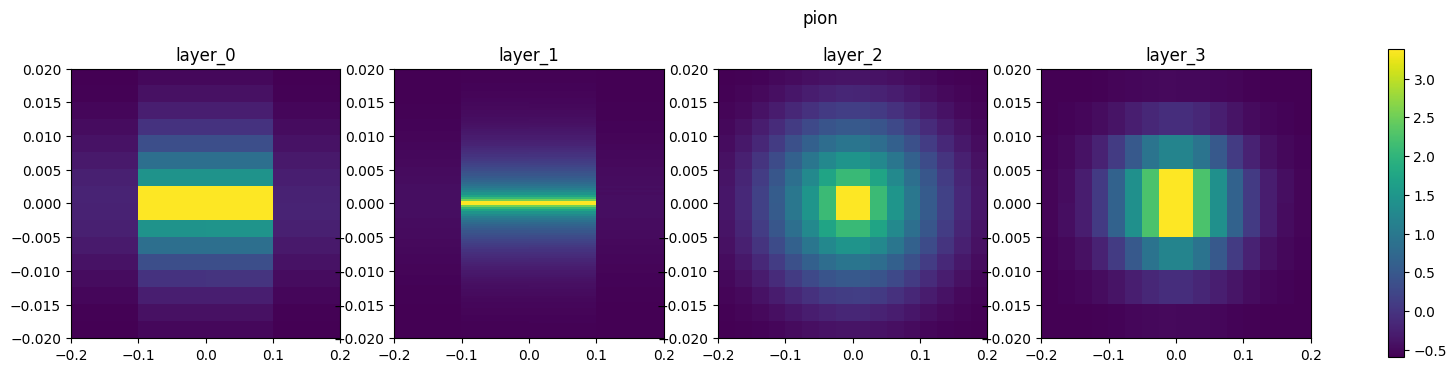

Processing layer_0
Processing layer_1
Processing layer_2
Processing layer_3
Layers for photon (class 1)


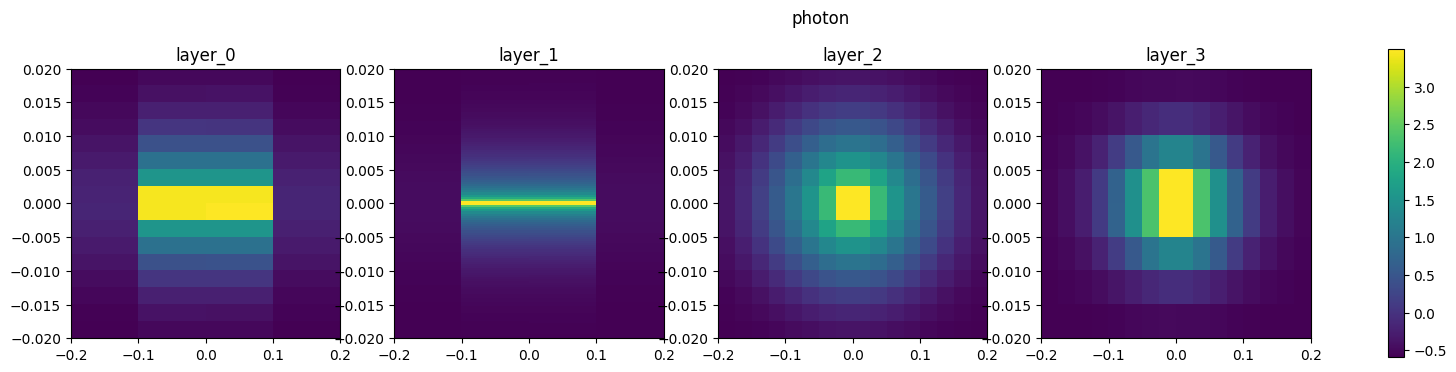

Processing layer_0
Processing layer_1
Processing layer_2
Processing layer_3
Layers for scalar (class 2)


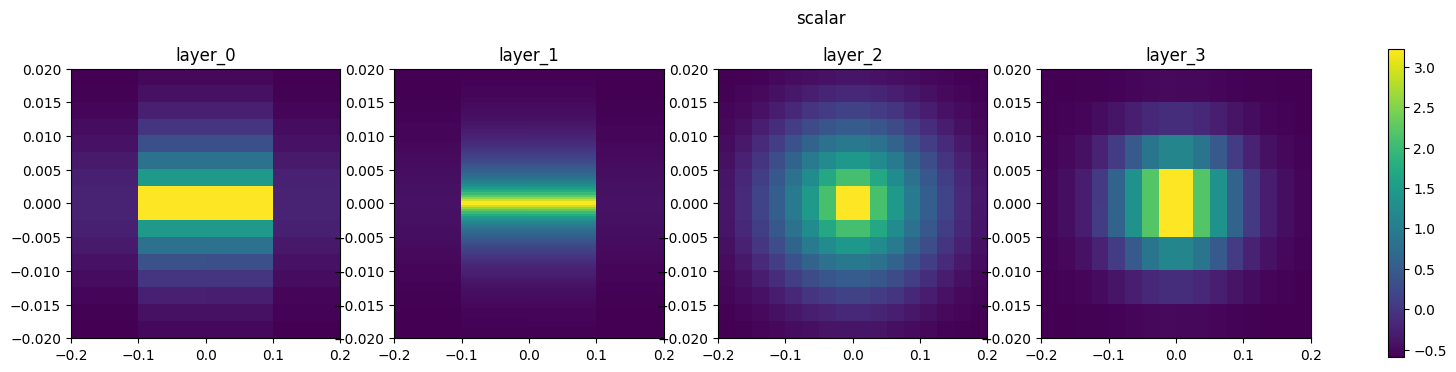

In [8]:
for i in range(3):
    graph_average_class(i)

## Split into train/dev/test

After this, we have three sets of jets:
- `jets_train` (210k)
- `jets_dev` (45k)
- `jets_test` (45k)

In [9]:
m = len(all_jets["label"])

f_train, f_dev, f_test = 0.7, 0.15, 0.15
n_train, n_dev, n_test = map(lambda x: int(m * x), (f_train, f_dev, f_test))

jets_train = {}
jets_dev = {}
jets_test = {}

for layer in all_jets.keys():
    print(f"Splitting layer {layer}...")
    jets_train[layer] = all_jets[layer][:n_train]
    jets_dev[layer] = all_jets[layer][n_train:(n_train + n_dev)]
    jets_test[layer] = all_jets[layer][(n_train + n_dev):]

Splitting layer layer_0...
Splitting layer layer_1...
Splitting layer layer_2...
Splitting layer layer_3...
Splitting layer energy...
Splitting layer overflow...
Splitting layer label...


In [10]:
def total_size(jets):
    res = 0
    for layer in jets:
        res += jets[layer].nbytes
    return convert_size(res)

print(f"n_train: {n_train} ({total_size(jets_train)})")
print(f"n_dev: {n_dev} ({total_size(jets_dev)})")
print(f"n_test: {n_test} ({total_size(jets_test)})")

n_train: 210000 (1.51 GB)
n_dev: 45000 (331.65 MB)
n_test: 45000 (331.65 MB)


## Create the model

Simple CNN.

In [11]:
import torch
from torchvision.transforms import Resize, InterpolationMode

In [12]:
for layer in all_jets.keys():
    print(layer.ljust(20), all_jets[layer].shape)

layer_0              (300000, 4, 16)
layer_1              (300000, 4, 128)
layer_2              (300000, 16, 16)
layer_3              (300000, 16, 8)
energy               (300000, 1)
overflow             (300000, 4)
label                (300000,)


In [13]:
class CNNModel(torch.nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        
        # Things for upsampling
        # "l0_tc" is "layer_0 transpose convolution"
        # https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html
        
        self.resize = Resize(size=(32, 32), interpolation=InterpolationMode.NEAREST, antialias=False)
        
        # Let's use LeNet: https://en.wikipedia.org/wiki/LeNet#/media/File:Comparison_image_neural_networks.svg
        channel_sizes = [10, 20]
        
        self.cnn1 = torch.nn.Conv2d(in_channels=4, out_channels=channel_sizes[0], kernel_size=5, stride=1, padding=2)
        self.maxpool1 = torch.nn.MaxPool2d(kernel_size=2)
        self.maxpool1_bn = torch.nn.BatchNorm2d(channel_sizes[0])

        self.cnn2 = torch.nn.Conv2d(in_channels=channel_sizes[0], out_channels=channel_sizes[1], kernel_size=5, stride=1, padding=2)
        self.maxpool2 = torch.nn.MaxPool2d(kernel_size=2)
        self.maxpool2_bn = torch.nn.BatchNorm2d(channel_sizes[1])

        self.fc1 = torch.nn.Linear(channel_sizes[1] * 8 * 8 + 5, 10)

    def forward(self, x):
        relu = torch.nn.functional.relu
        
        layer0 = self.resize(x["layer_0"])
        layer1 = self.resize(x["layer_1"])
        layer2 = self.resize(x["layer_2"])
        layer3 = self.resize(x["layer_3"])
        
        img = torch.stack([layer0, layer1, layer2, layer3], dim=1)

        conv1_out = relu(self.cnn1(img))
        pool1_out = self.maxpool1(conv1_out)
        pool1_out_bn = self.maxpool1_bn(pool1_out)

        conv2_out = relu(self.cnn2(pool1_out_bn))
        pool2_out = self.maxpool2(conv2_out)
        pool2_out_bn = self.maxpool2_bn(pool2_out)

        fcn_input = pool2_out.view(pool2_out_bn.size(0), -1)        
        fcn_input = torch.cat((fcn_input, x["energy"], x["overflow"]), dim=1)
        fc1_out = self.fc1(fcn_input)

        return fc1_out

### Select hyperparameters

In [14]:
torch.manual_seed(55)

model = CNNModel()

learning_rate = 1e-3
epochs = 10
batchsize = 500

loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

if torch.cuda.is_available():
    model.to(0)

In [15]:
import gc
gc.collect()
torch.cuda.empty_cache()

print("allocated:", convert_size(torch.cuda.memory_allocated()))
print("reserved:", convert_size(torch.cuda.memory_reserved()))

allocated: 81.0 KB
reserved: 2.0 MB


### Begin training

In [16]:
# Placeholders for training loss and dev accuracy during training
# Training loss should be tracked for each iteration (1 iteration -> single forward pass to the network)
# dev accuracy should be evaluated every 'Epoch' (1 epoch -> full training dataset)
# If using batch gradient, 1 iteration = 1 epoch

train_loss_list = []
train_accuracy_list = []
dev_accuracy_list = []

In [17]:
def to_torch(jets):
    res = {}
    for key in jets:
        res[key] = torch.from_numpy(jets[key])
        if np.issubdtype(jets[key].dtype, float):
            res[key] = res[key].float().to(0)
        elif np.issubdtype(jets[key].dtype, int):
            res[key] = res[key].long().to(0)
    return res

def split_batches(jets, batchsize):
    m = len(jets["label"])
    n_batches = m // batchsize
    
    d_wise = {}
    for key in jets:
        d_wise[key] = np.array_split(jets[key], n_batches)
        
    batches = []
    for i in range(n_batches):
        batches.append({key: d_wise[key][i] for key in d_wise})
    
    return batches

torch_dev = to_torch(jets_dev)
train_batched = split_batches(to_torch(jets_train), batchsize)

batch_split_num = len(train_batched)

In [18]:
for epoch in range(5):
    correct = 0
    
    for b in tqdm(range(batch_split_num)):
        optimizer.zero_grad()
        
        outputs = model(train_batched[b])
        loss = loss_func(outputs, train_batched[b]["label"])        
        loss.backward() # Compute gradients        
        
        predictions = torch.argmax(outputs, dim=1)
        correct += torch.sum((predictions == train_batched[b]["label"]).type(torch.FloatTensor))
        
        train_loss_list.append(loss.item())

        optimizer.step() # Update parameters
        
    train_accuracy_list.append((correct / len(jets_train["label"])).item())
        
    # Compute dev accuracy
    with torch.no_grad():
        predictions = torch.argmax(model(torch_dev), dim=1)
        correct = predictions == torch_dev["label"]
        accuracy = torch.mean(correct.type(torch.FloatTensor))
        dev_accuracy_list.append(accuracy.item())        
    
    # Print a report
    tl = str(round(train_loss_list[-1], 5)).ljust(7)      # Training loss
    ta = str(round(train_accuracy_list[-1], 5)).ljust(7)  # Training accuracy
    da = str(round(dev_accuracy_list[-1], 5)).ljust(7)    # Dev accuracy
    desc = f"Epoch {epoch}, tl={tl}, ta={ta}, da={da}"
    
    #pbar.set_description(desc)
    print(desc)

100%|██████████| 420/420 [00:15<00:00, 27.49it/s] 


Epoch 0, tl=0.28983, ta=0.78569, da=0.88787


100%|██████████| 420/420 [00:03<00:00, 121.21it/s]


Epoch 1, tl=0.19741, ta=0.90875, da=0.91987


100%|██████████| 420/420 [00:03<00:00, 121.23it/s]


Epoch 2, tl=0.16964, ta=0.93332, da=0.92856


100%|██████████| 420/420 [00:03<00:00, 119.91it/s]


Epoch 3, tl=0.15447, ta=0.94064, da=0.93784


100%|██████████| 420/420 [00:03<00:00, 121.25it/s]


Epoch 4, tl=0.14309, ta=0.94505, da=0.94622
